In [1]:
import json
import glob
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from asap3 import EMT
from ase.io import write, read

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from surface_seg.envs.symmetry_function import make_snn_params, wrap_symmetry_functions


In [4]:
def sortby(x):
    try:
        return int(x.split('_')[-1].split('.traj')[0])
    except ValueError:
        return float('inf')
    
def _get_fingerprints(atoms, snn_params):
    #get fingerprints from amptorch as better state space feature
    fps = wrap_symmetry_functions(atoms, snn_params)
    fp_length = fps.shape[-1]
    return fps, fp_length

def get_features(traj_list, use_fingerprints=False):
    features = []
    energies = []
    for traj in tqdm.tqdm(traj_list):
        structure =  read(traj, index=':')
        initial_structure = structure[0]
        initial_structure.set_calculator(EMT())
        initial_energy = initial_structure.get_potential_energy()
        free_atoms = list(set(range(len(initial_structure))) -
                                       set(initial_structure.constraints[0].get_indices()))
        for atoms in structure:
            atoms.set_calculator(EMT())
            energies.append(atoms.get_potential_energy() - initial_energy)
            if use_fingerprints:
                _feature, fp_length = _get_fingerprints(atoms, snn_params)
            else:
                _feature = atoms.positions
            features.append(_feature[free_atoms])
            
    return np.array(features), np.array(energies)


def plot_PCA(fps, energies, scaled=False, n_components=2):
    if scaled:
        fps = StandardScaler().fit_transform(fps)
        
    data = pd.DataFrame(data=fps)
    pca = PCA(n_components=n_components)
    pca.fit(data)
    pca_data = pca.transform(data)
    pca_data = pd.DataFrame(pca_data[:,:2], columns = ['pc1', 'pc2'])
    pca_data['energies'] = energies
    
#     #plot PCA
#     %matplotlib inline
#     plt.figure(figsize=(12,10))
#     plt.scatter(pca_data['pc1'], pca_data['pc2'], c = pca_data['energies'], linewidths=10, alpha=0.7)
#     plt.xlabel('pc 1', fontsize=20)
#     plt.ylabel('pc 2', fontsize=20)
#     cbar = plt.colorbar()
#     cbar.set_label("energies", fontsize=20)
# #     plt.show()
#     return 
    return pca_data

# Load entire trajectories

In [3]:
fps_params_dir = './result_trpo/fps/fps_params.txt'
traj_dir = './result_trpo/fps/trajectories/*.traj'

with open(fps_params_dir, 'r') as f:
    fps_params = json.load(f)
descriptors = fps_params['descriptors']
elements = fps_params['elements']
snn_params = make_snn_params(elements, *descriptors)

traj_list = glob.glob(traj_dir)
print('Load %d trajectories' %len(traj_list))
traj_list.sort(key=sortby)

Load 23 trajectories


# Generate features (fingerprints or positions)

In [5]:
features, energies = get_features(traj_list, use_fingerprints=True) 
#### NOTES
# Saving fingerprints in each episode takes ~1.5 MB
# Saving .traj only takes ~500 kB, but generating fingerprints afterward takes ~10s per episode

100%|██████████| 23/23 [03:39<00:00,  9.56s/it]


# Plot PCA for each atom

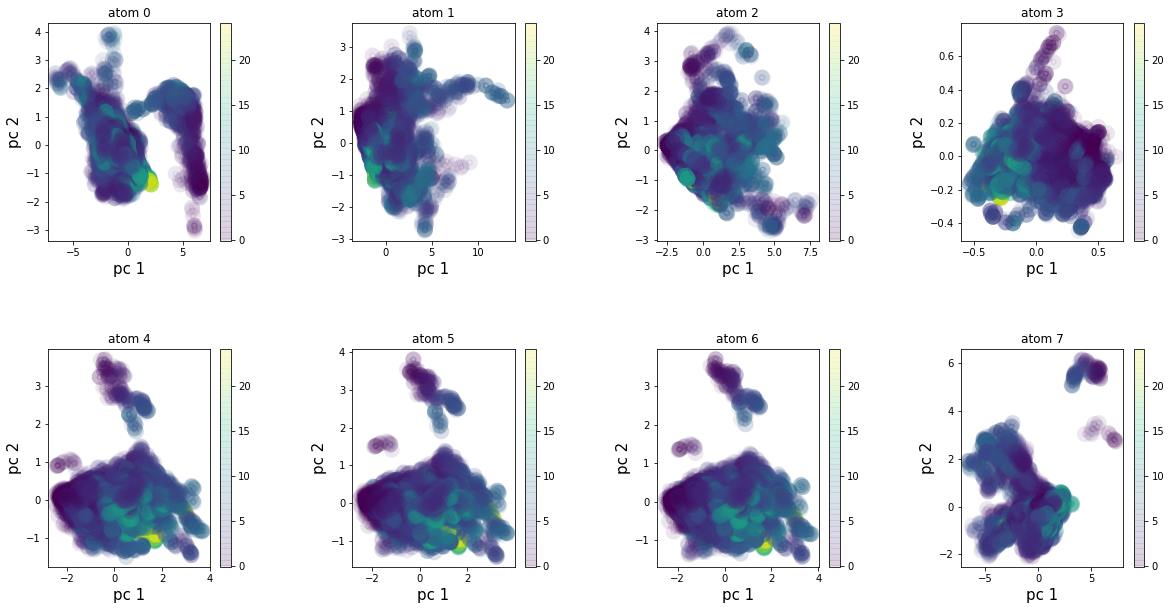

In [7]:
%matplotlib inline

fig, axs = plt.subplots(2, 4, figsize=(20,10))
fig.subplots_adjust(hspace =.5, wspace=.5)

axs = axs.ravel()

for i in range(features.shape[1]): # for each free atom,
    pca_data = plot_PCA(features[:,i], energies)
    
    pca = axs[i].scatter(pca_data['pc1'], pca_data['pc2'], c = pca_data['energies'], linewidths=10, alpha=0.1)
    axs[i].set_xlabel('pc 1', fontsize=15)
    axs[i].set_ylabel('pc 2', fontsize=15)
    axs[i].set_title('atom %d' %i)
    fig.colorbar(pca, ax = axs[i])

plt.show()

#### NOTES
# PCA was performed separately for each atom. So each atom may have different principal components
# Need to find a way for the Featurization at the structure level